In [1]:
import sys
sys.path.append('C:/Users/kupec/OneDrive/Desktop/neuroforest-main/neuroforest-master')
from typing import List

import numpy as np
from IPython import display
from PIL import Image, ImageDraw, ImageFilter, ImageOps
from PIL.ImageEnhance import Contrast
from tqdm import tqdm

from neuroforest.dataset import dataloader, Coordinates, NeuroForestSample
from main import to_vect


Loading data from : C:\Users\kupec\OneDrive\Desktop\neuroforest-main\data_2022\trajectories_processed


In [2]:
sample = next(iter(dataloader))
session = sample["patchy"]
if session is None:
    print("No session")
    sys.exit(1)
ZOOM_FACTOR = 3.0

def transform(coords: List[Coordinates], offset: np.ndarray, factor: float) -> np.ndarray:
    return (to_vect(coords) + offset) * factor
mushrooms_coords = transform(session.mushroom_coords, np.array([200, 0, 200]), ZOOM_FACTOR)
mushrooms_coords = mushrooms_coords[:,[0,2]]
player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
player_coords = player_coords[:,[0,2]]
max_coord_x = int(mushrooms_coords[:,0].max())
max_coord_z = int(mushrooms_coords[:,1].max())

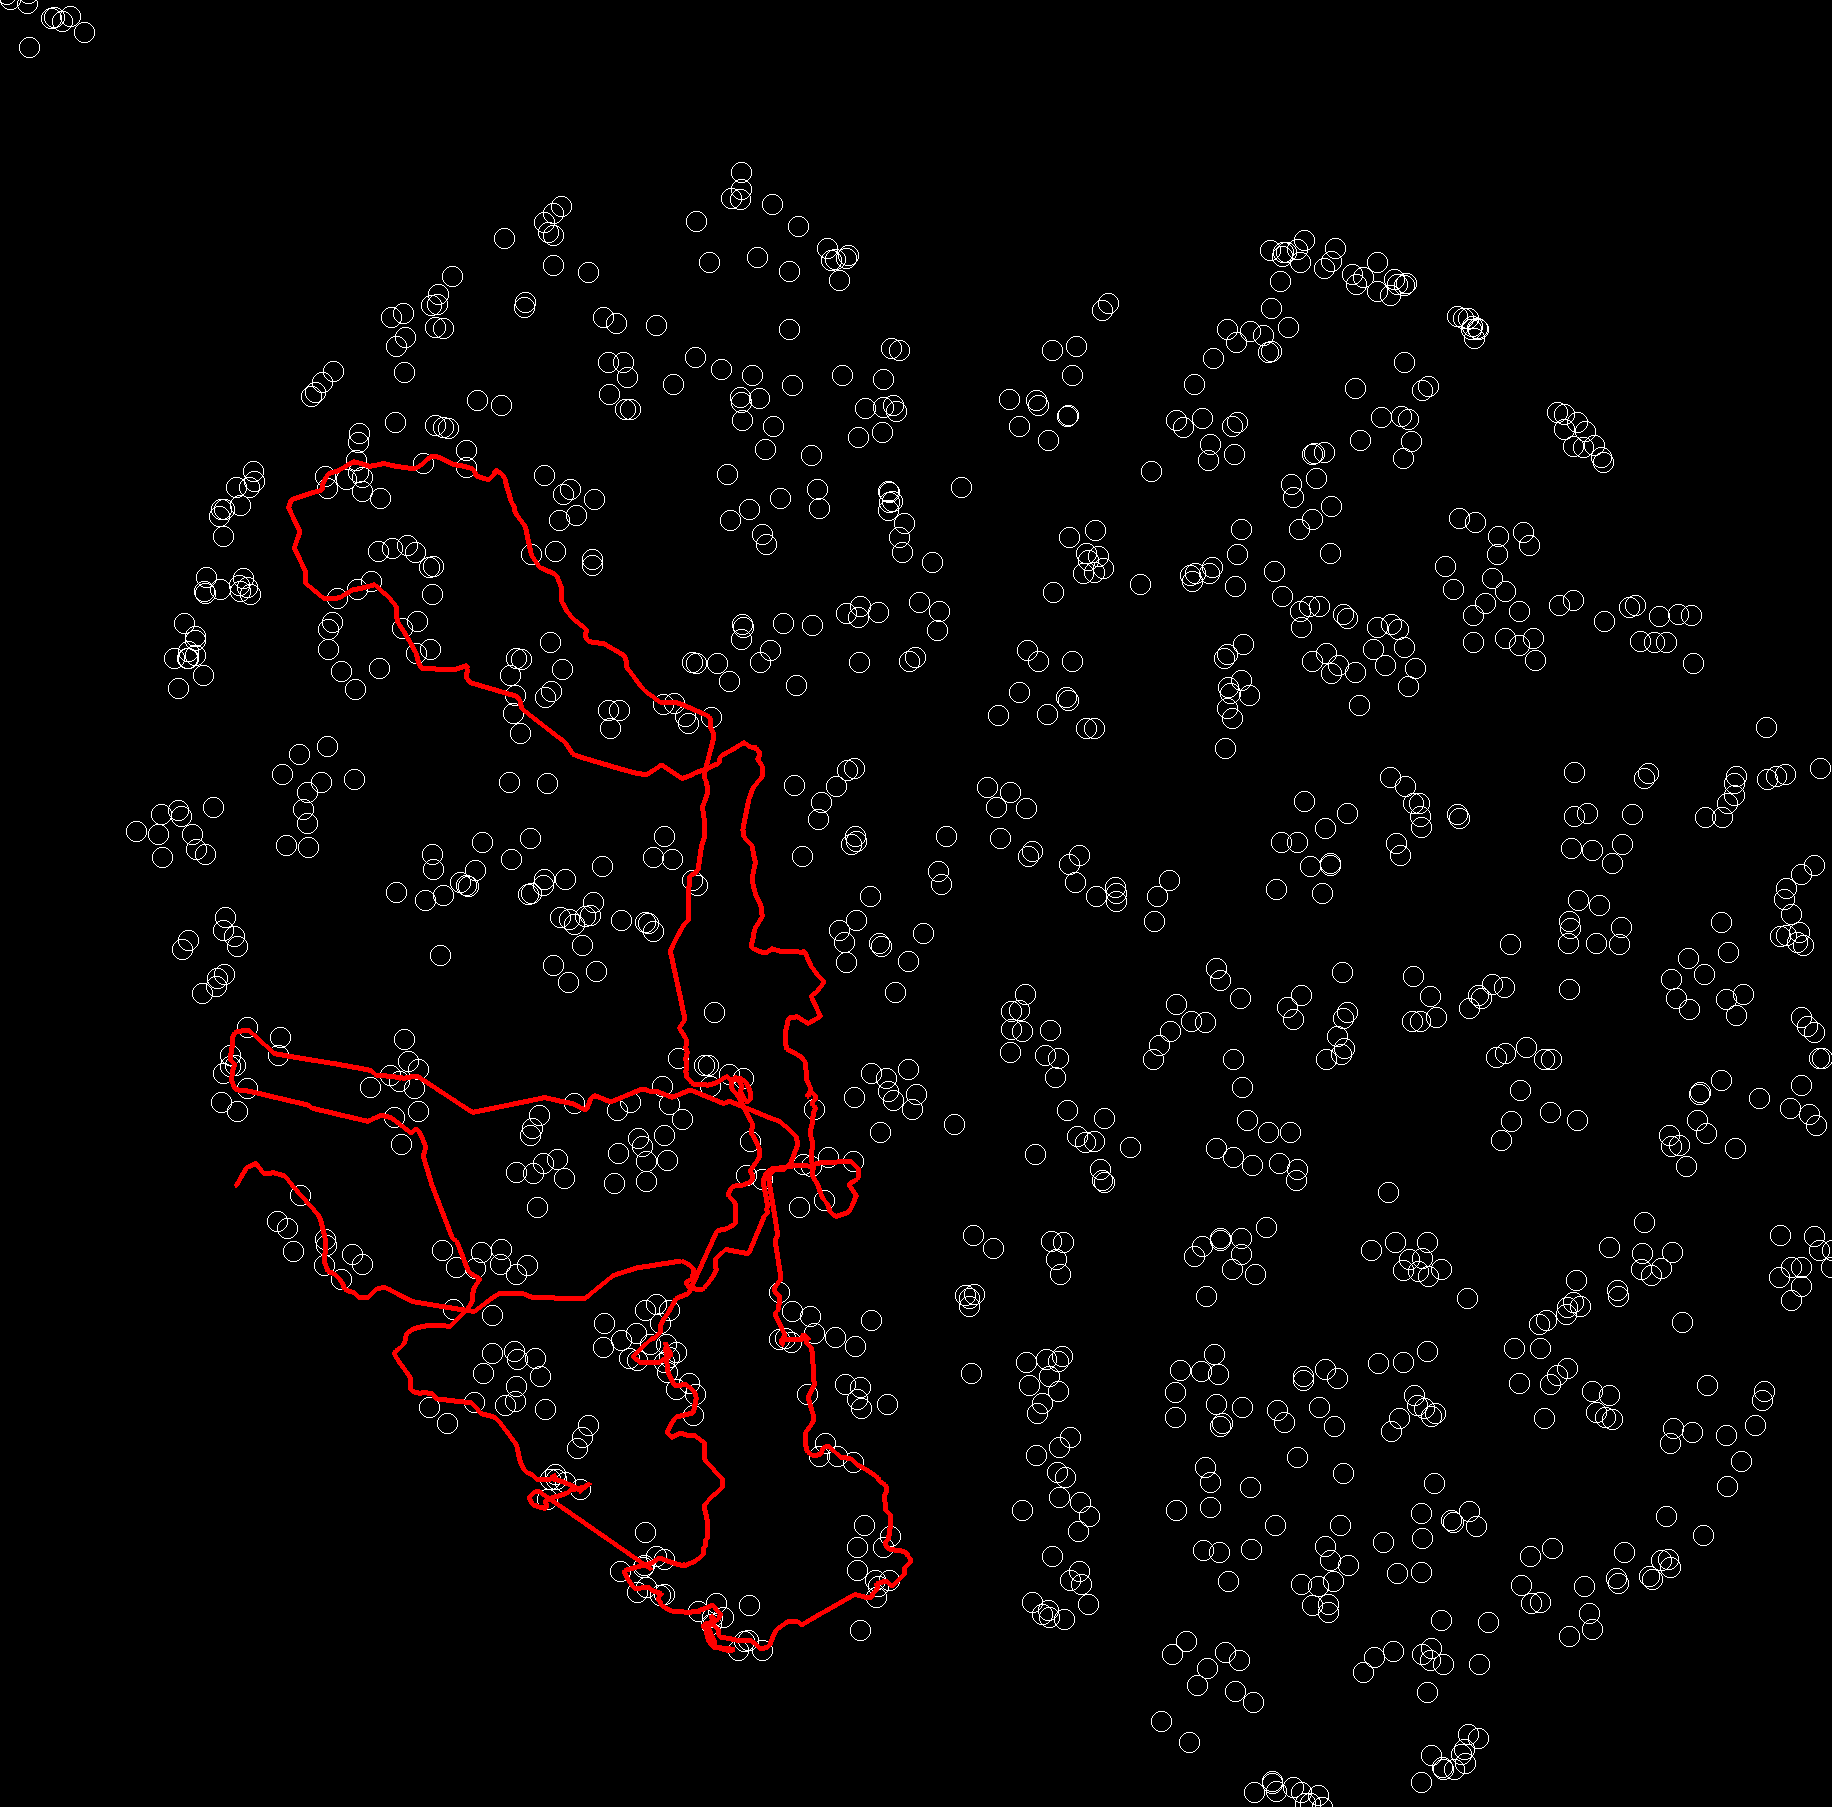

In [3]:

with Image.new(mode="RGB", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    for m in mushrooms_coords:
        draw.ellipse((tuple((m - 10).astype(int)), tuple((m + 10).astype(int)) ))
    draw.line([tuple(p) for p in player_coords.astype(int)], fill=(255,0,0), width=5)
    display.display(im)
img_shrooms = im

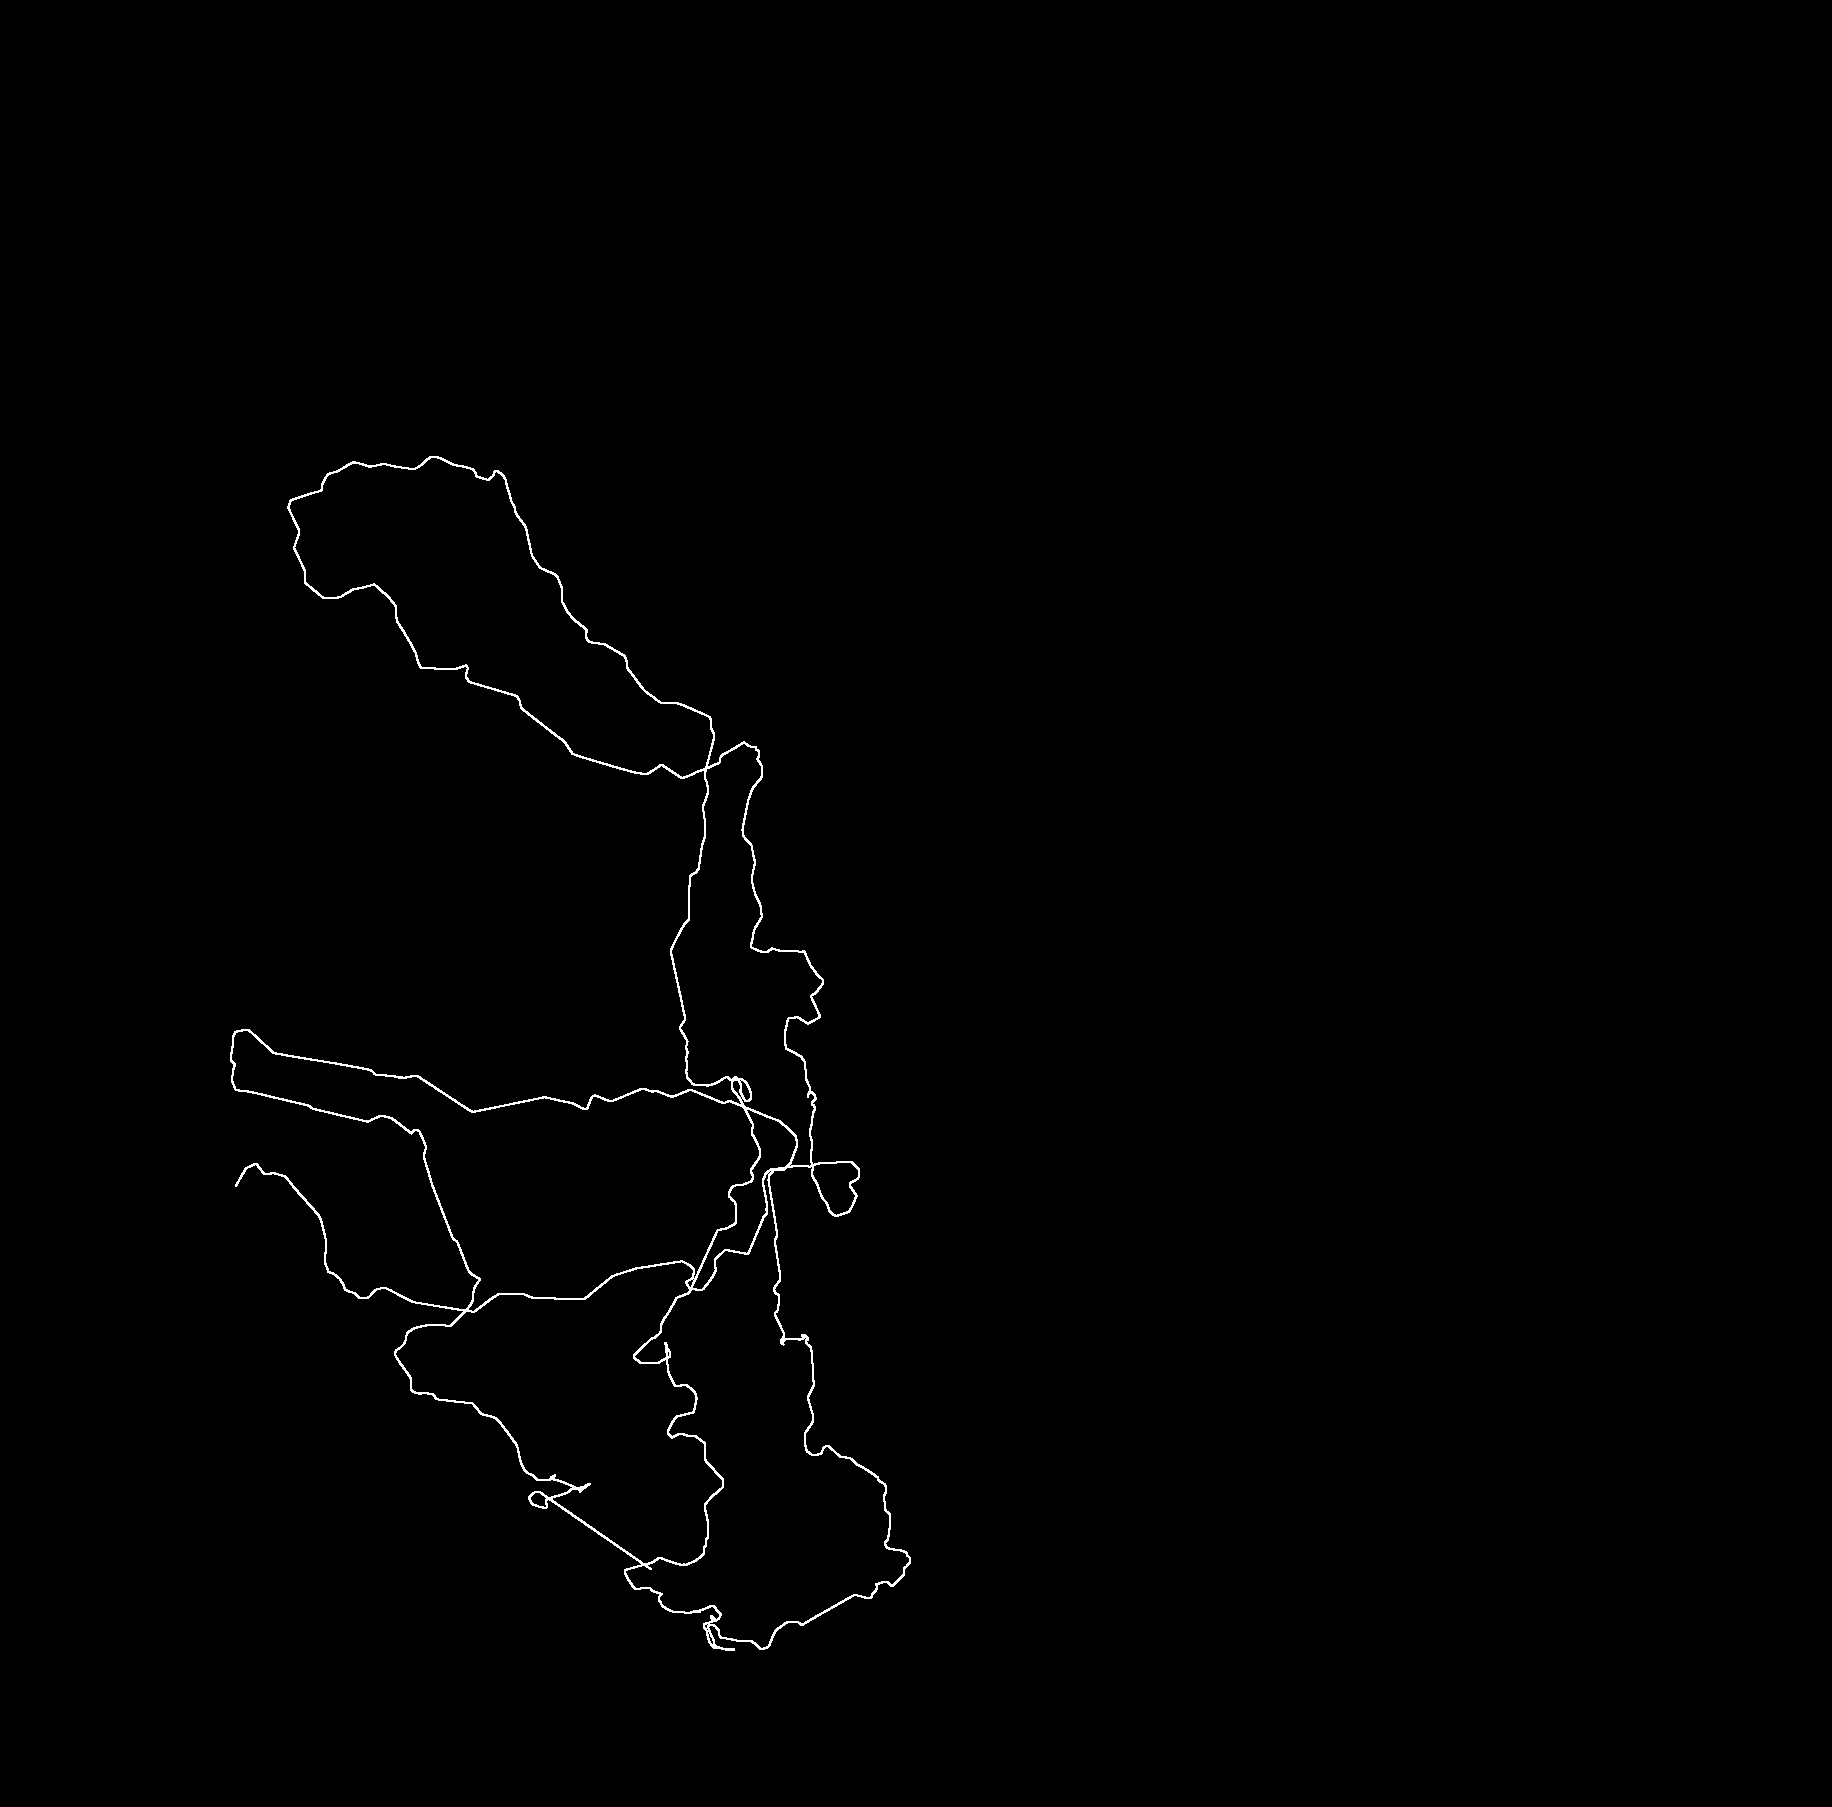

In [4]:
with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
    draw = ImageDraw.Draw(im)
    draw.line([tuple(p) for p in player_coords.astype(int)],fill=1, width=2)
    display.display(im)
    player_trajectory = np.array(im)

for first


100%|██████████| 41/41 [00:29<00:00,  1.39it/s]
C:\Users\kupec\AppData\Local\Temp\ipykernel_5836\3226581967.py:22: RuntimeWarning: divide by zero encountered in log
  log_scaled = np.log(overlayed_trajectories)
C:\Users\kupec\AppData\Local\Temp\ipykernel_5836\3226581967.py:24: RuntimeWarning: invalid value encountered in cast
  img = Image.fromarray(normed.astype(np.uint8))


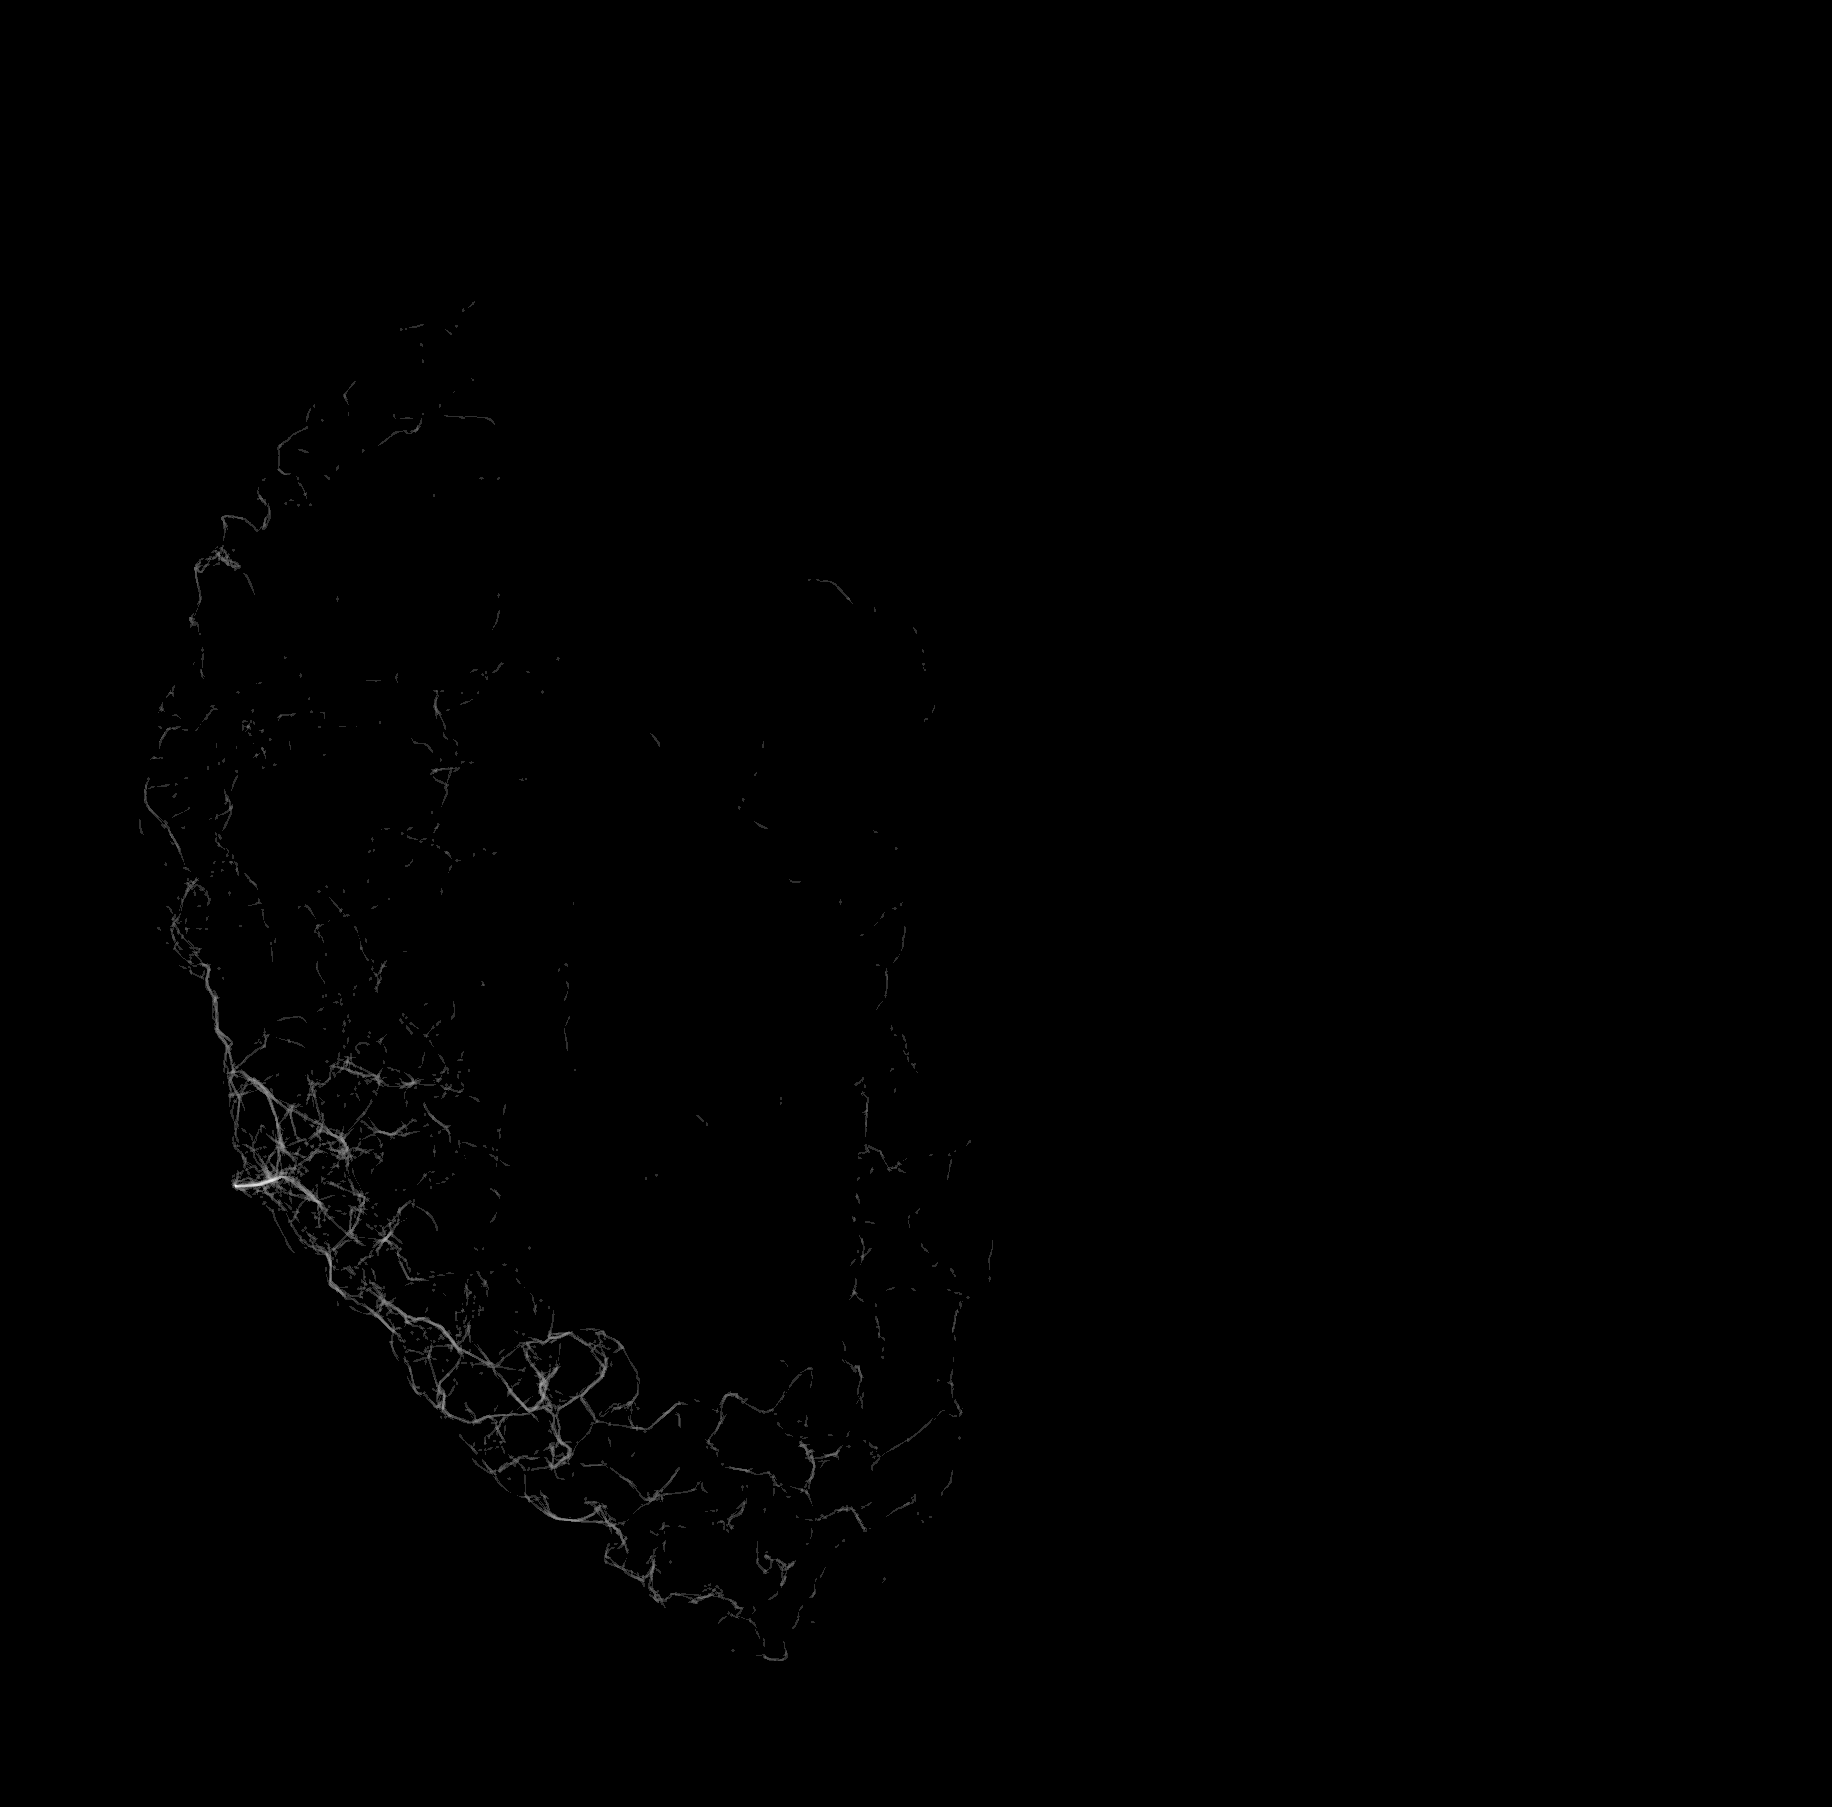

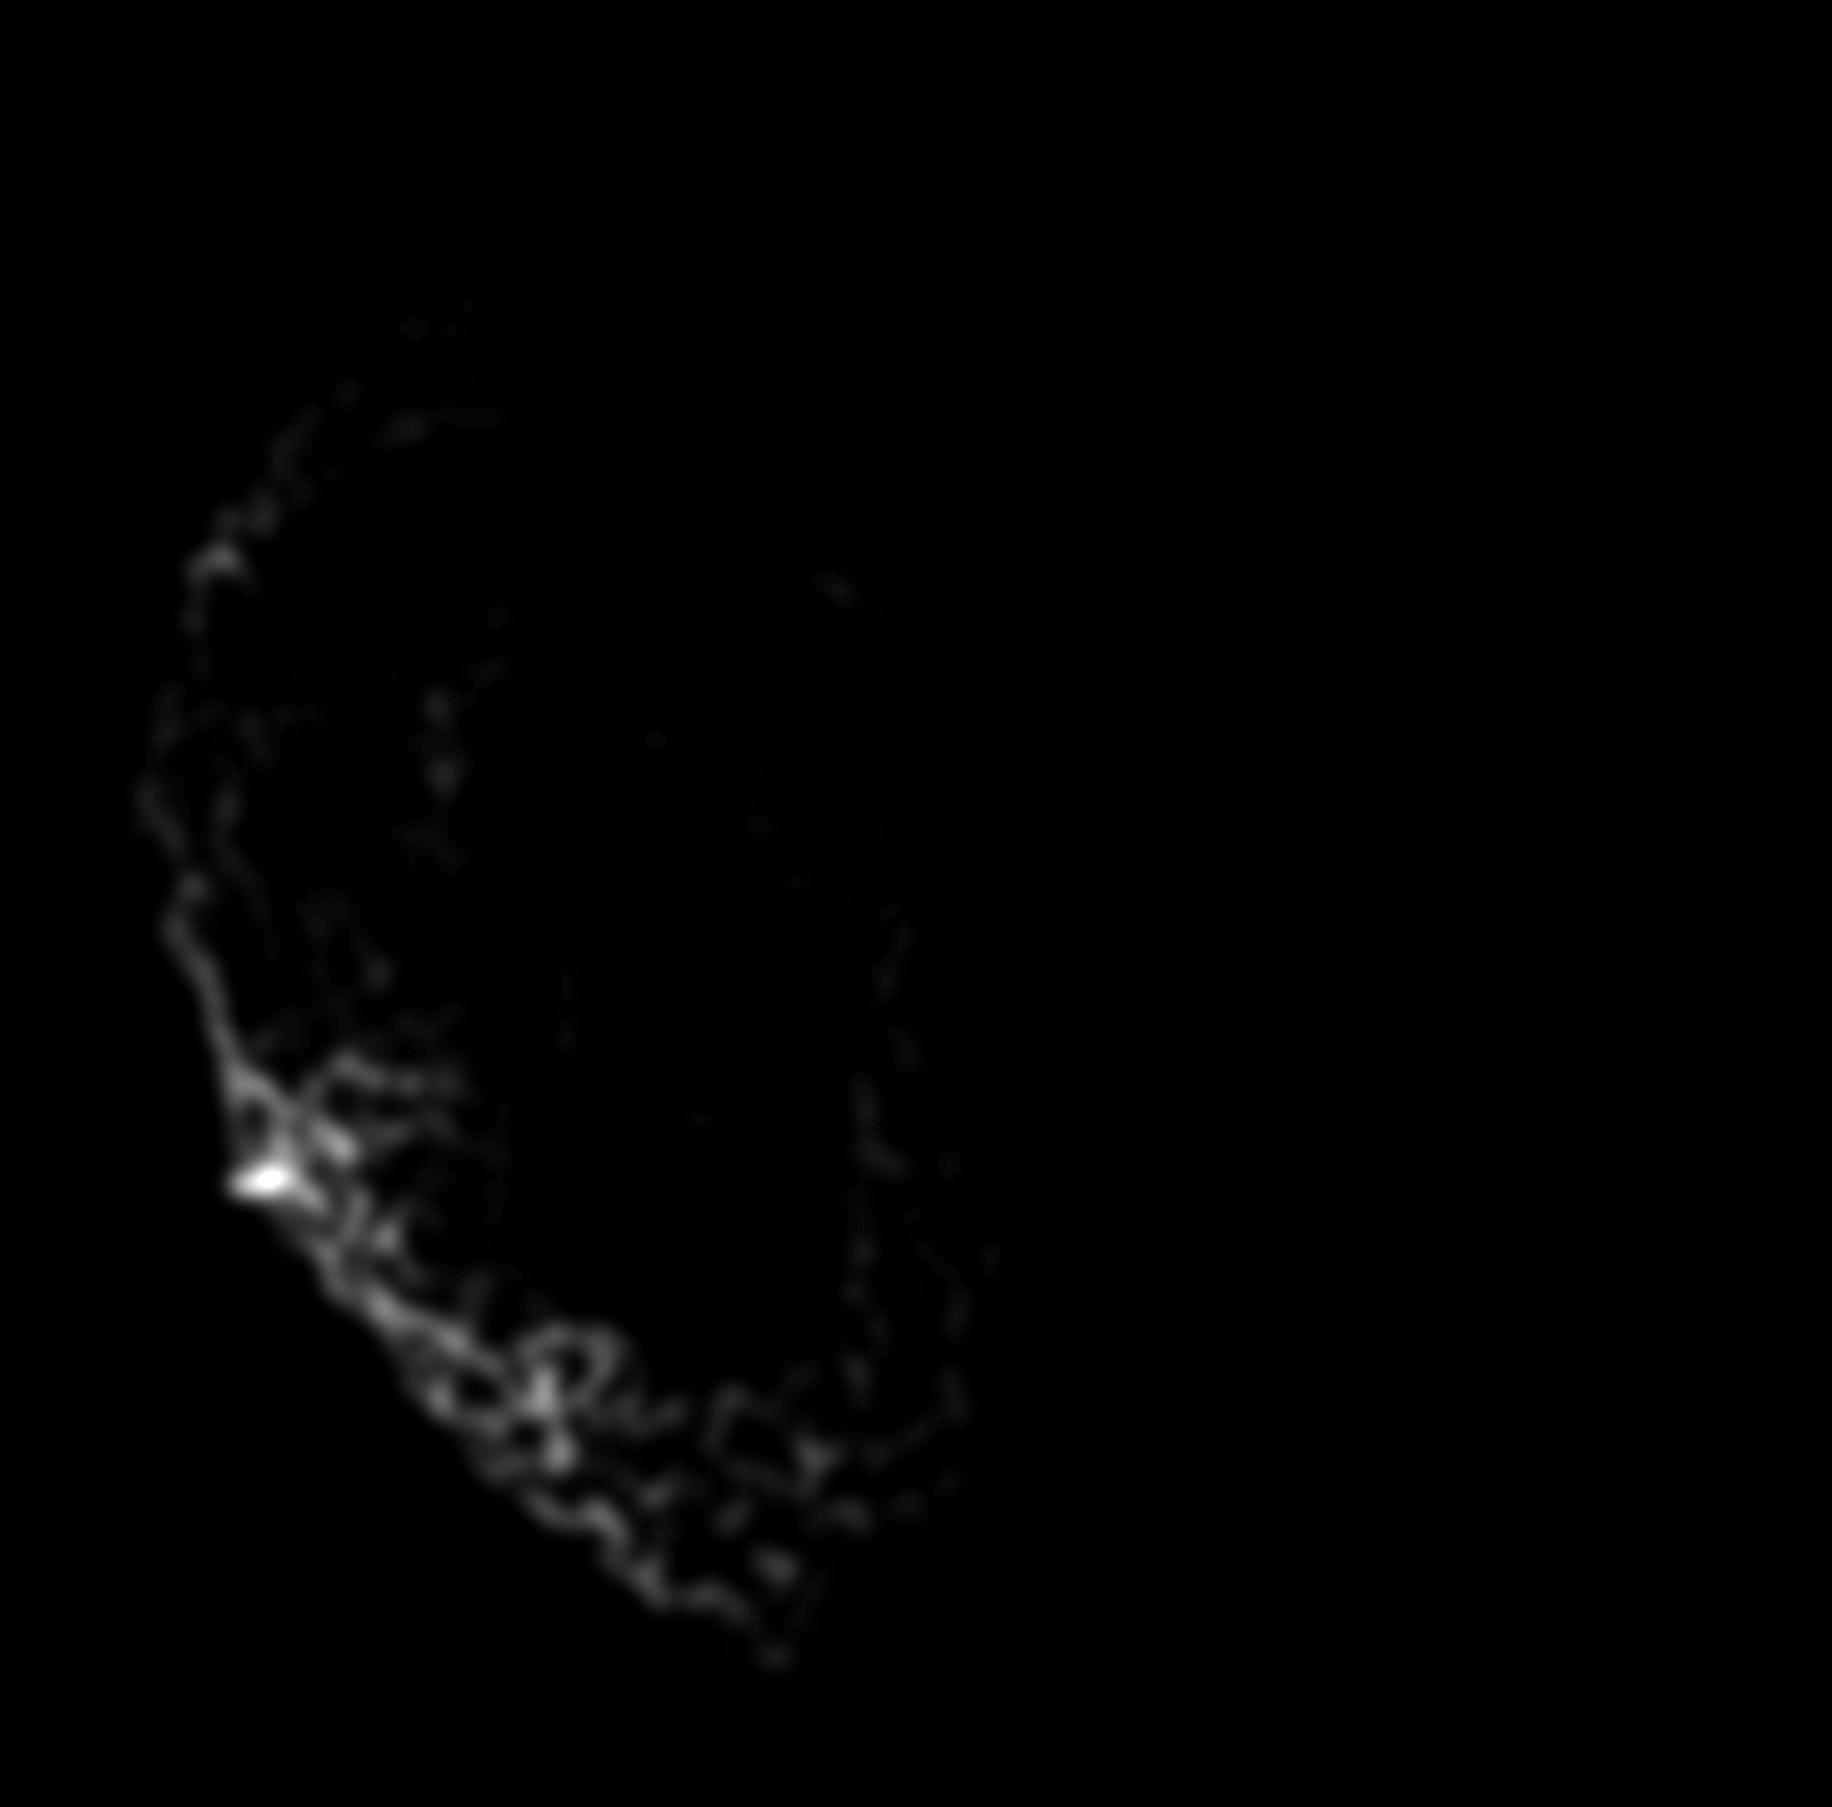

for patchy


100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


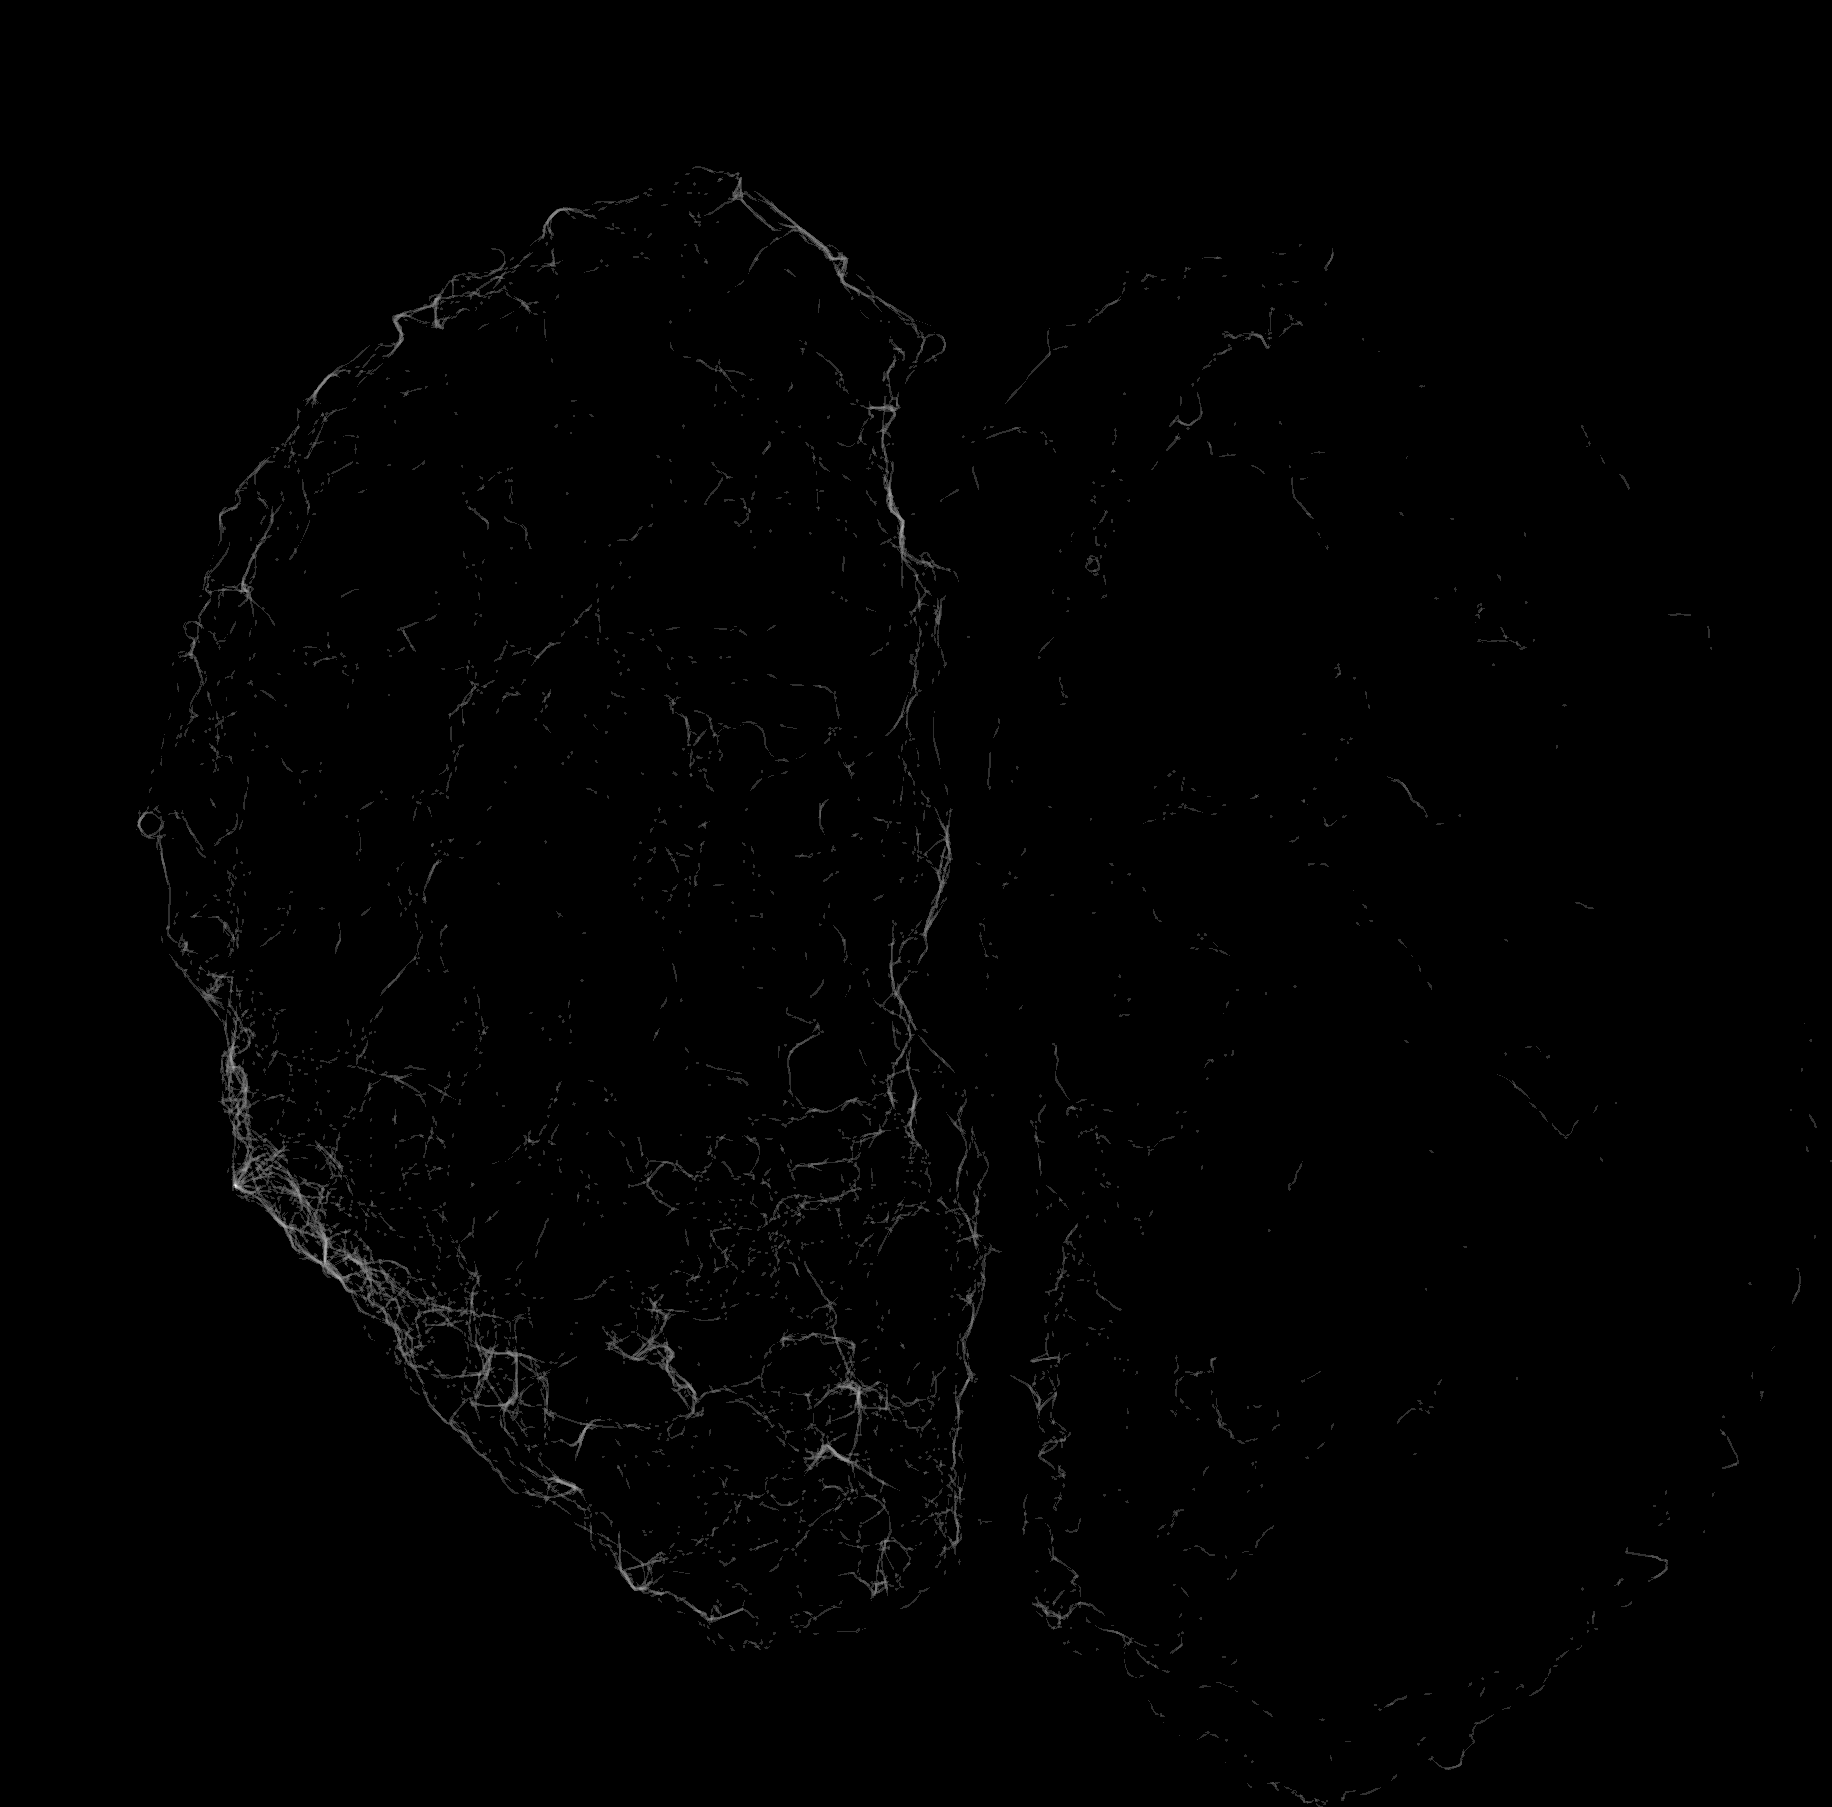

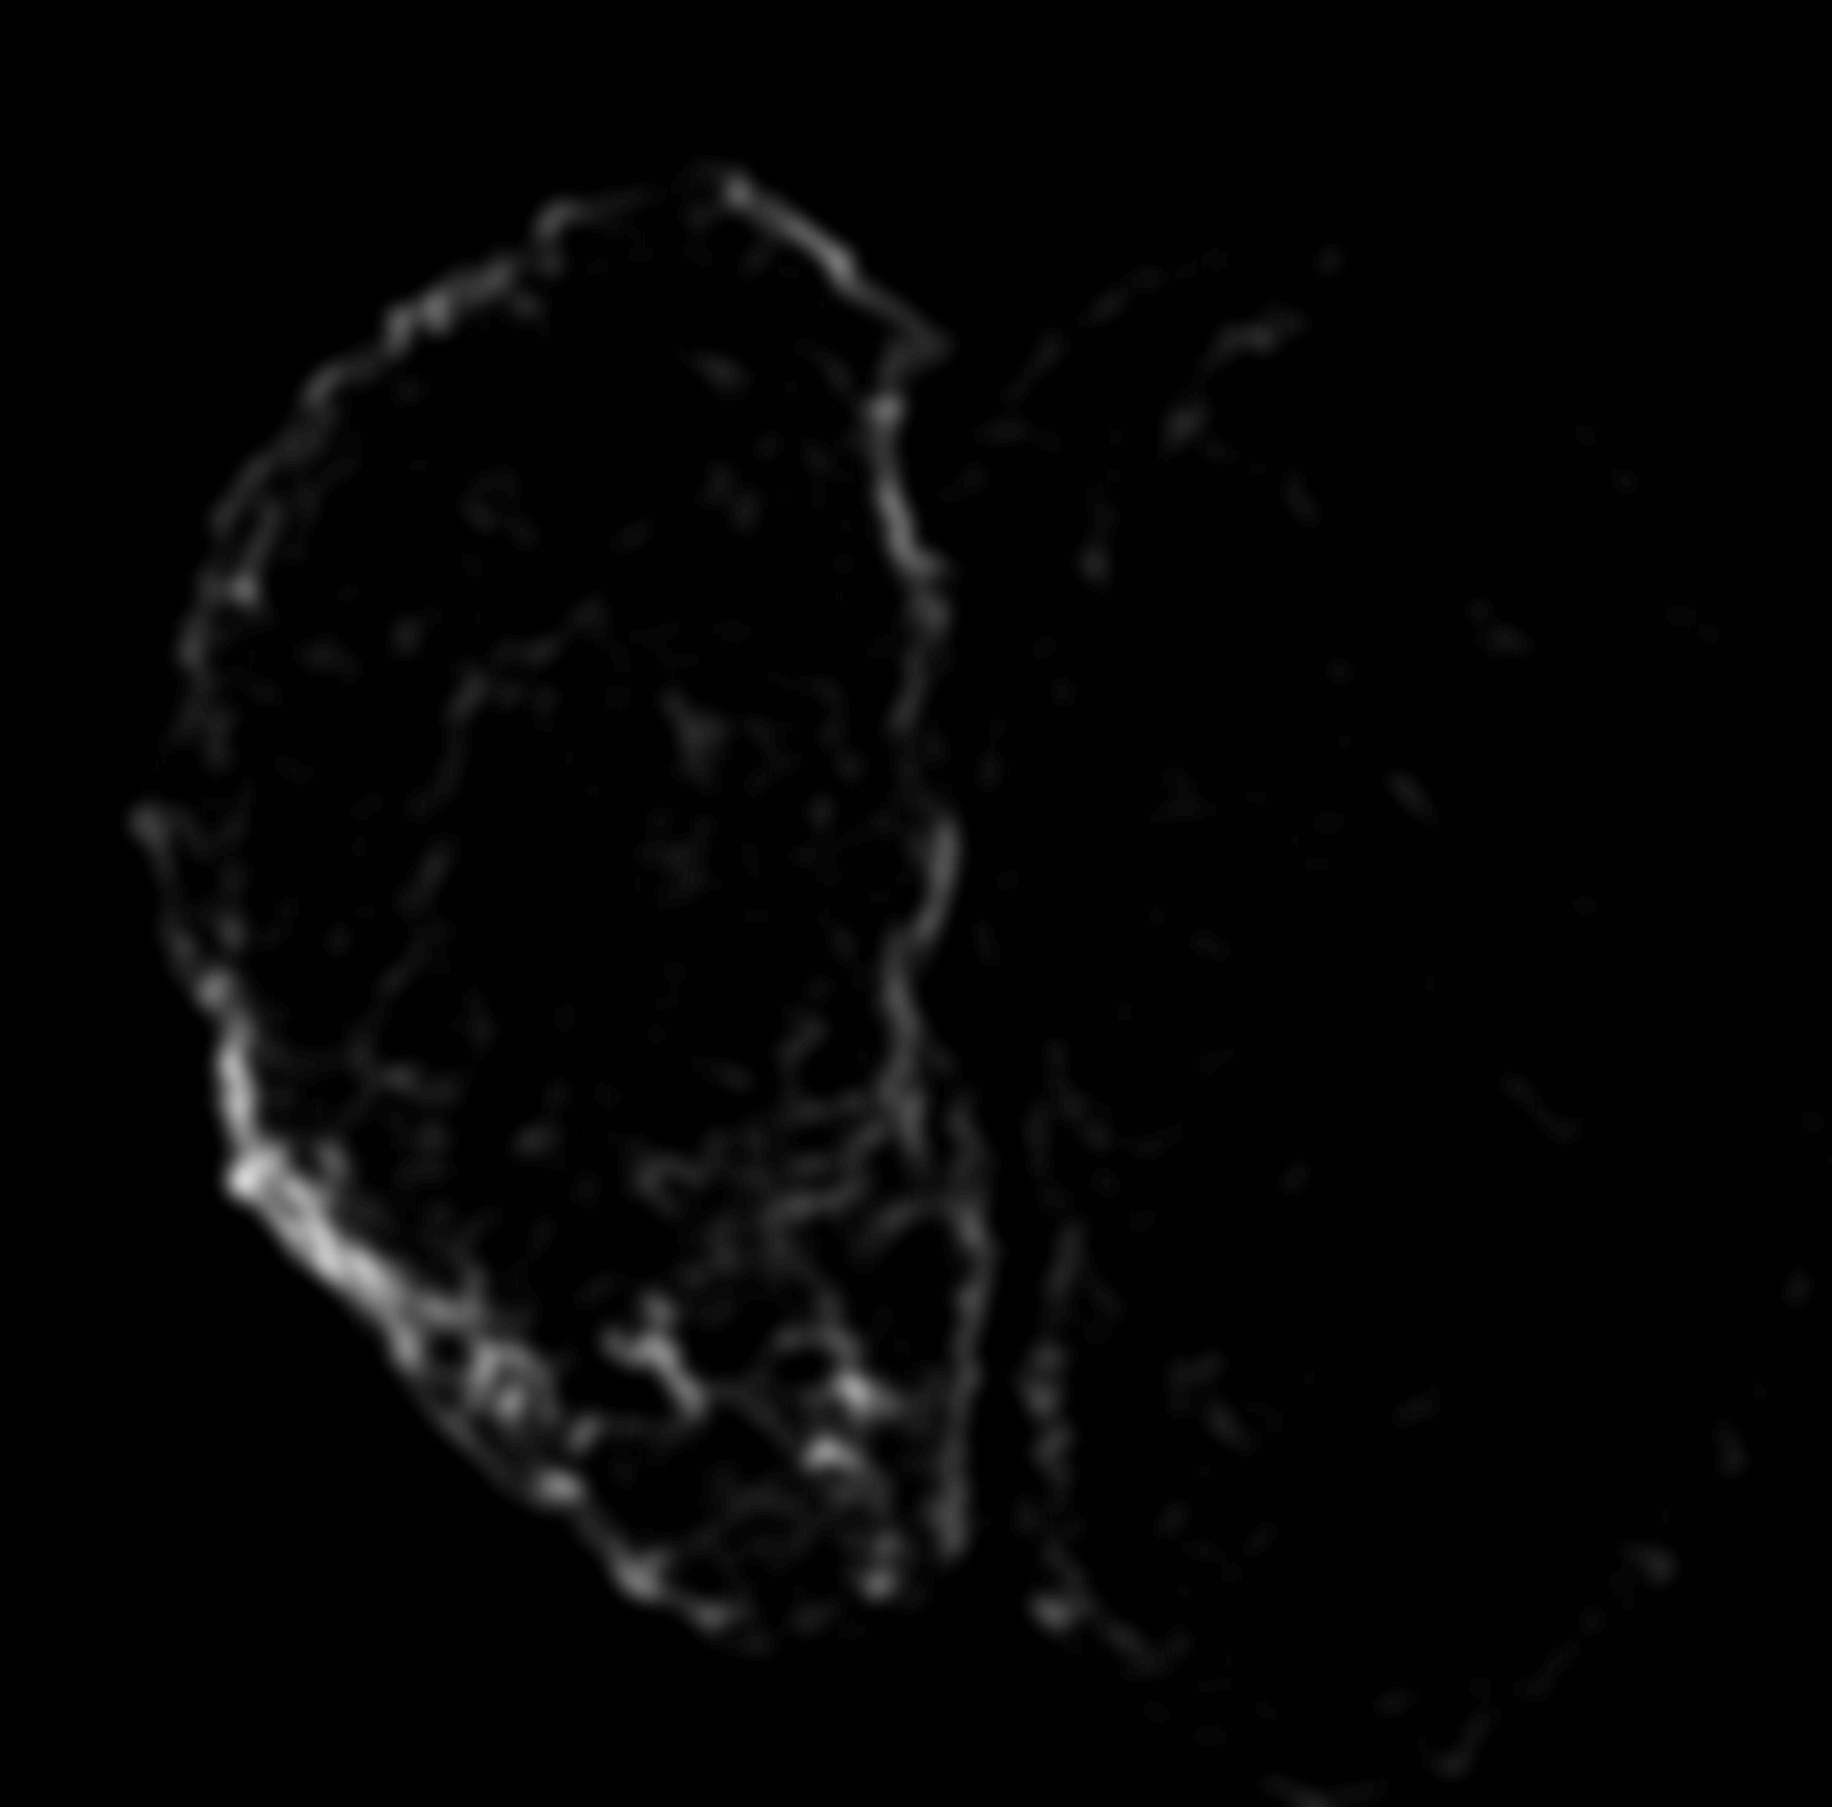

for uniform


100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


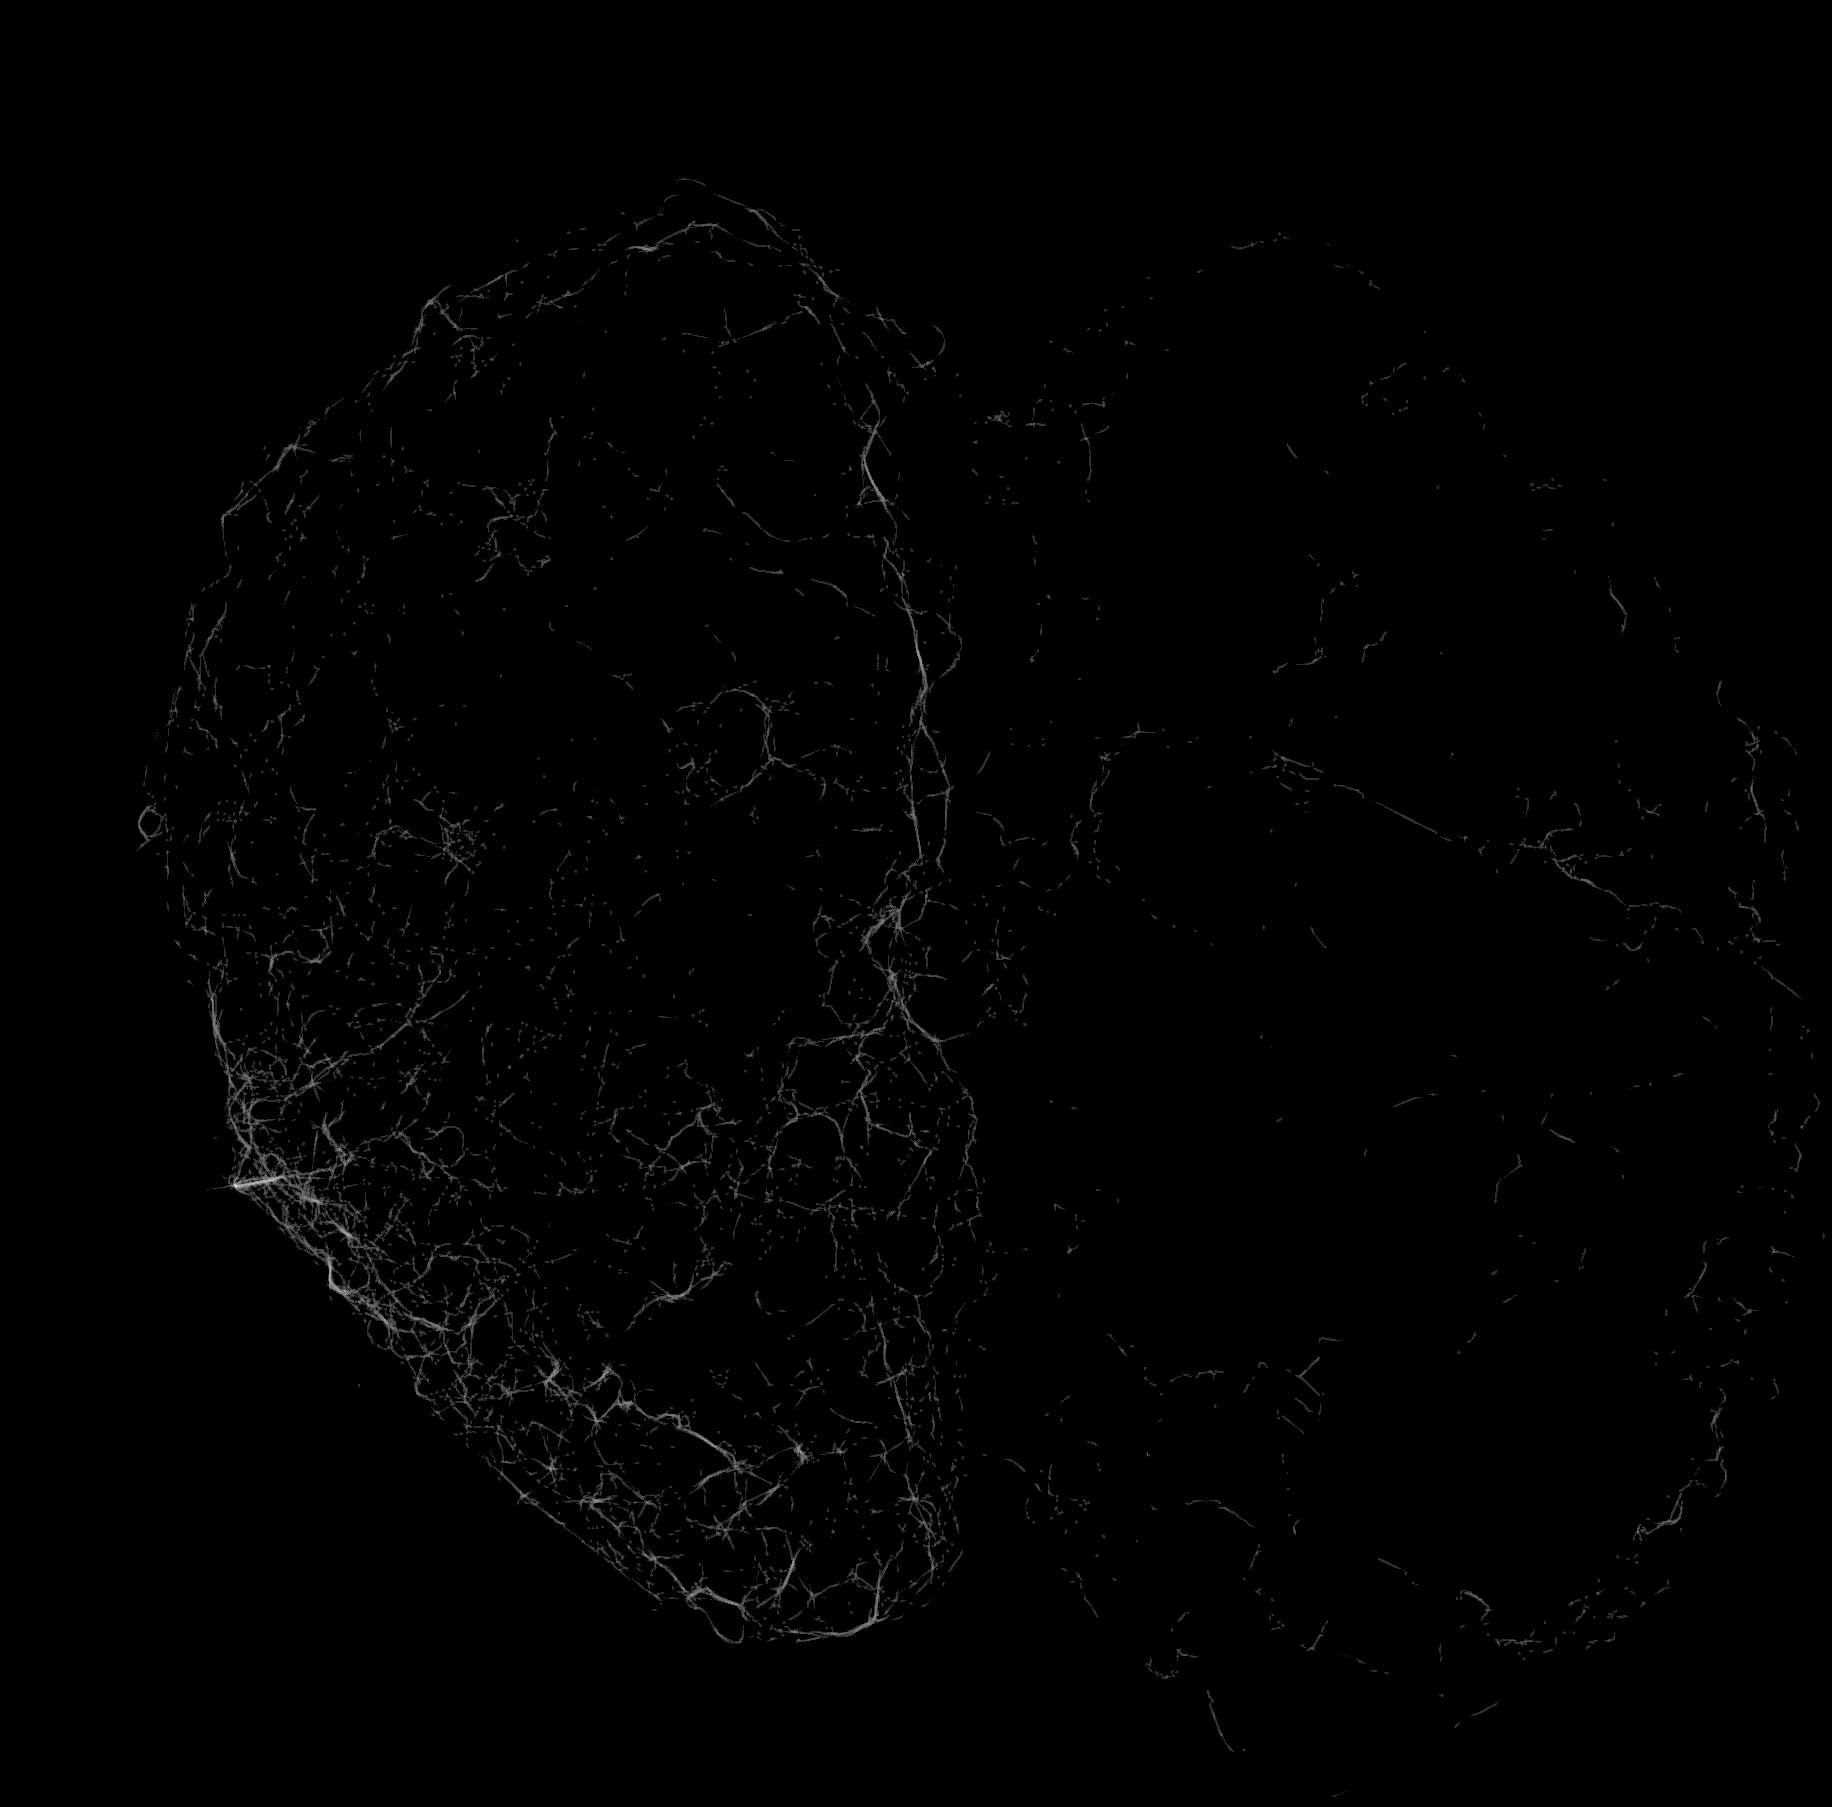

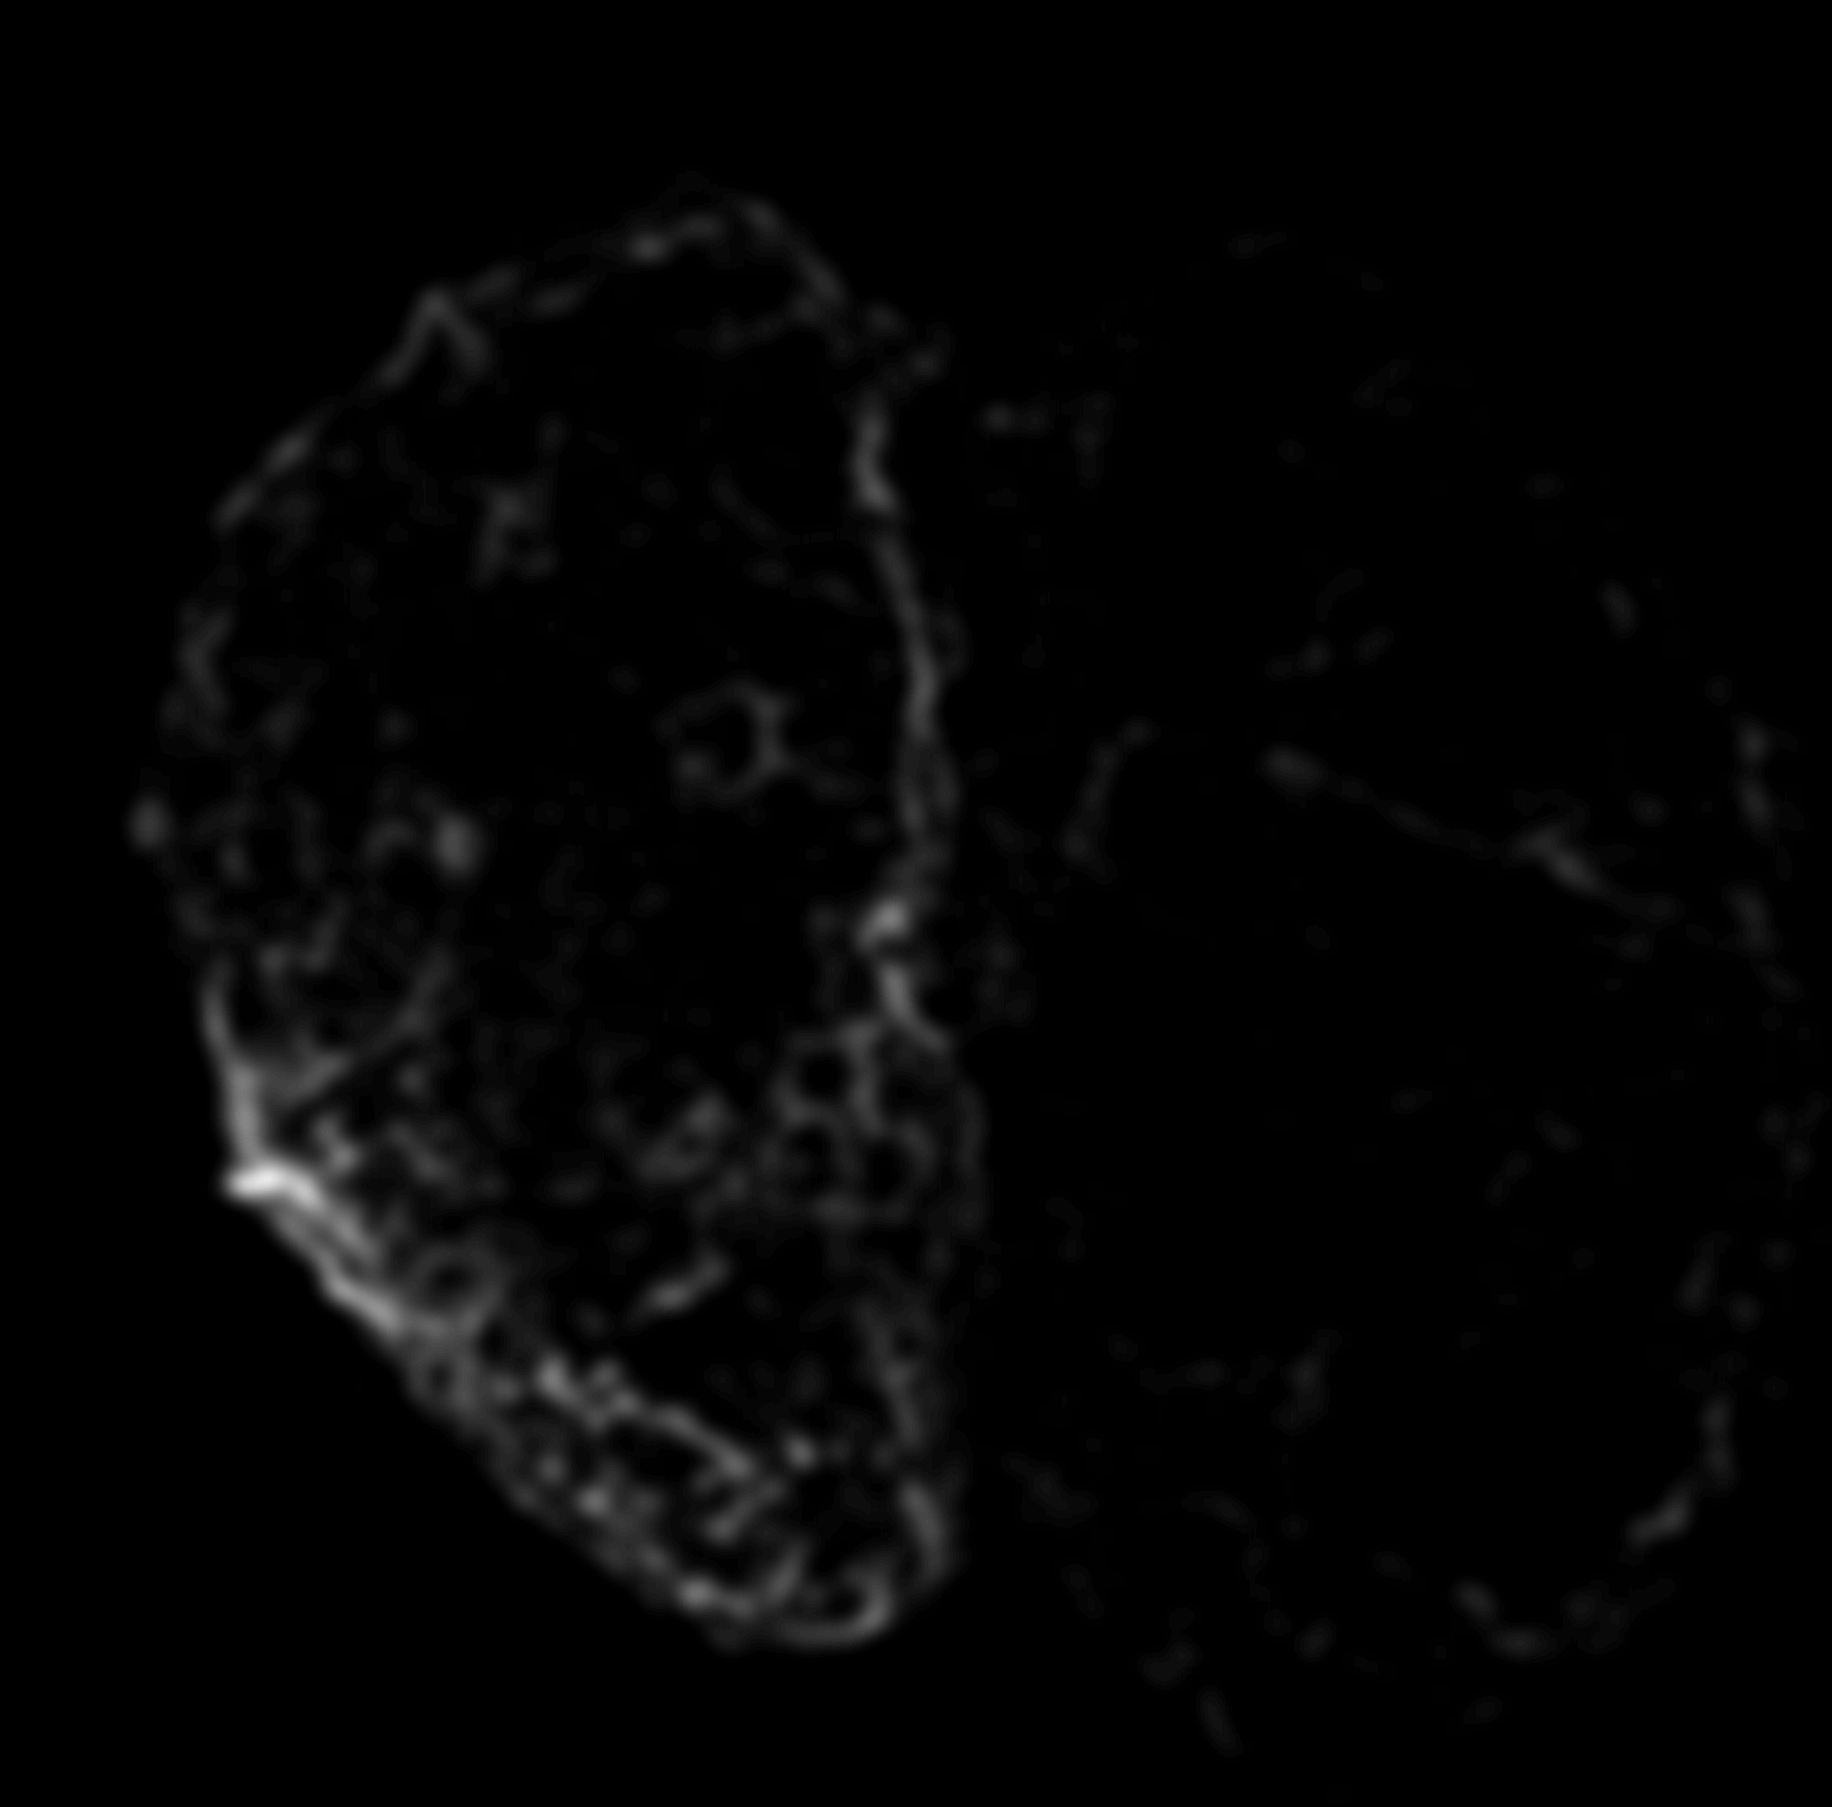

In [5]:
def get_trajectory_array(player_data: NeuroForestSample, session: str) -> np.ndarray:
    session = player_data[session]
    if session is None:
        return None
    player_coords = transform([c["coord"] for c in session.player_coords], np.array([200, 0, 200]), ZOOM_FACTOR)
    player_coords = player_coords[:,[0,2]]

    with Image.new(mode="1", size=(max_coord_x, max_coord_z)) as im:
        draw = ImageDraw.Draw(im)
        draw.line([tuple(p) for p in player_coords.astype(int)],fill=1, width=2)
        return np.array(im)

for session_type in ["first", "patchy", "uniform"]:
    print(f"for {session_type}")
    overlayed_trajectories = np.zeros((max_coord_z, max_coord_x), dtype=int)
    for player_data in tqdm(dataloader):
        trajectory_array = get_trajectory_array(player_data, session_type)
        if trajectory_array is None:
            continue
        else :
            overlayed_trajectories += get_trajectory_array(player_data, session_type)
    log_scaled = np.log(overlayed_trajectories)
    normed = (log_scaled / log_scaled.max()) * 255
    img = Image.fromarray(normed.astype(np.uint8))
    display.display(img)
    img = img.filter(ImageFilter.GaussianBlur(radius = 10))
    img = Contrast(img).enhance(4)
    display.display(img)

In [6]:
img_inverted = ImageOps.invert(img)
np.mean(np.array(img_inverted).flatten()), np.mean(np.array(img).flatten())
img_inverted.show()

In [7]:
null_img = Image.new("L", img.size)
shrooms_rgba = img_shrooms.copy()
shrooms_rgba.putalpha(img_shrooms.convert("1"))
shrooms_rgba.show()

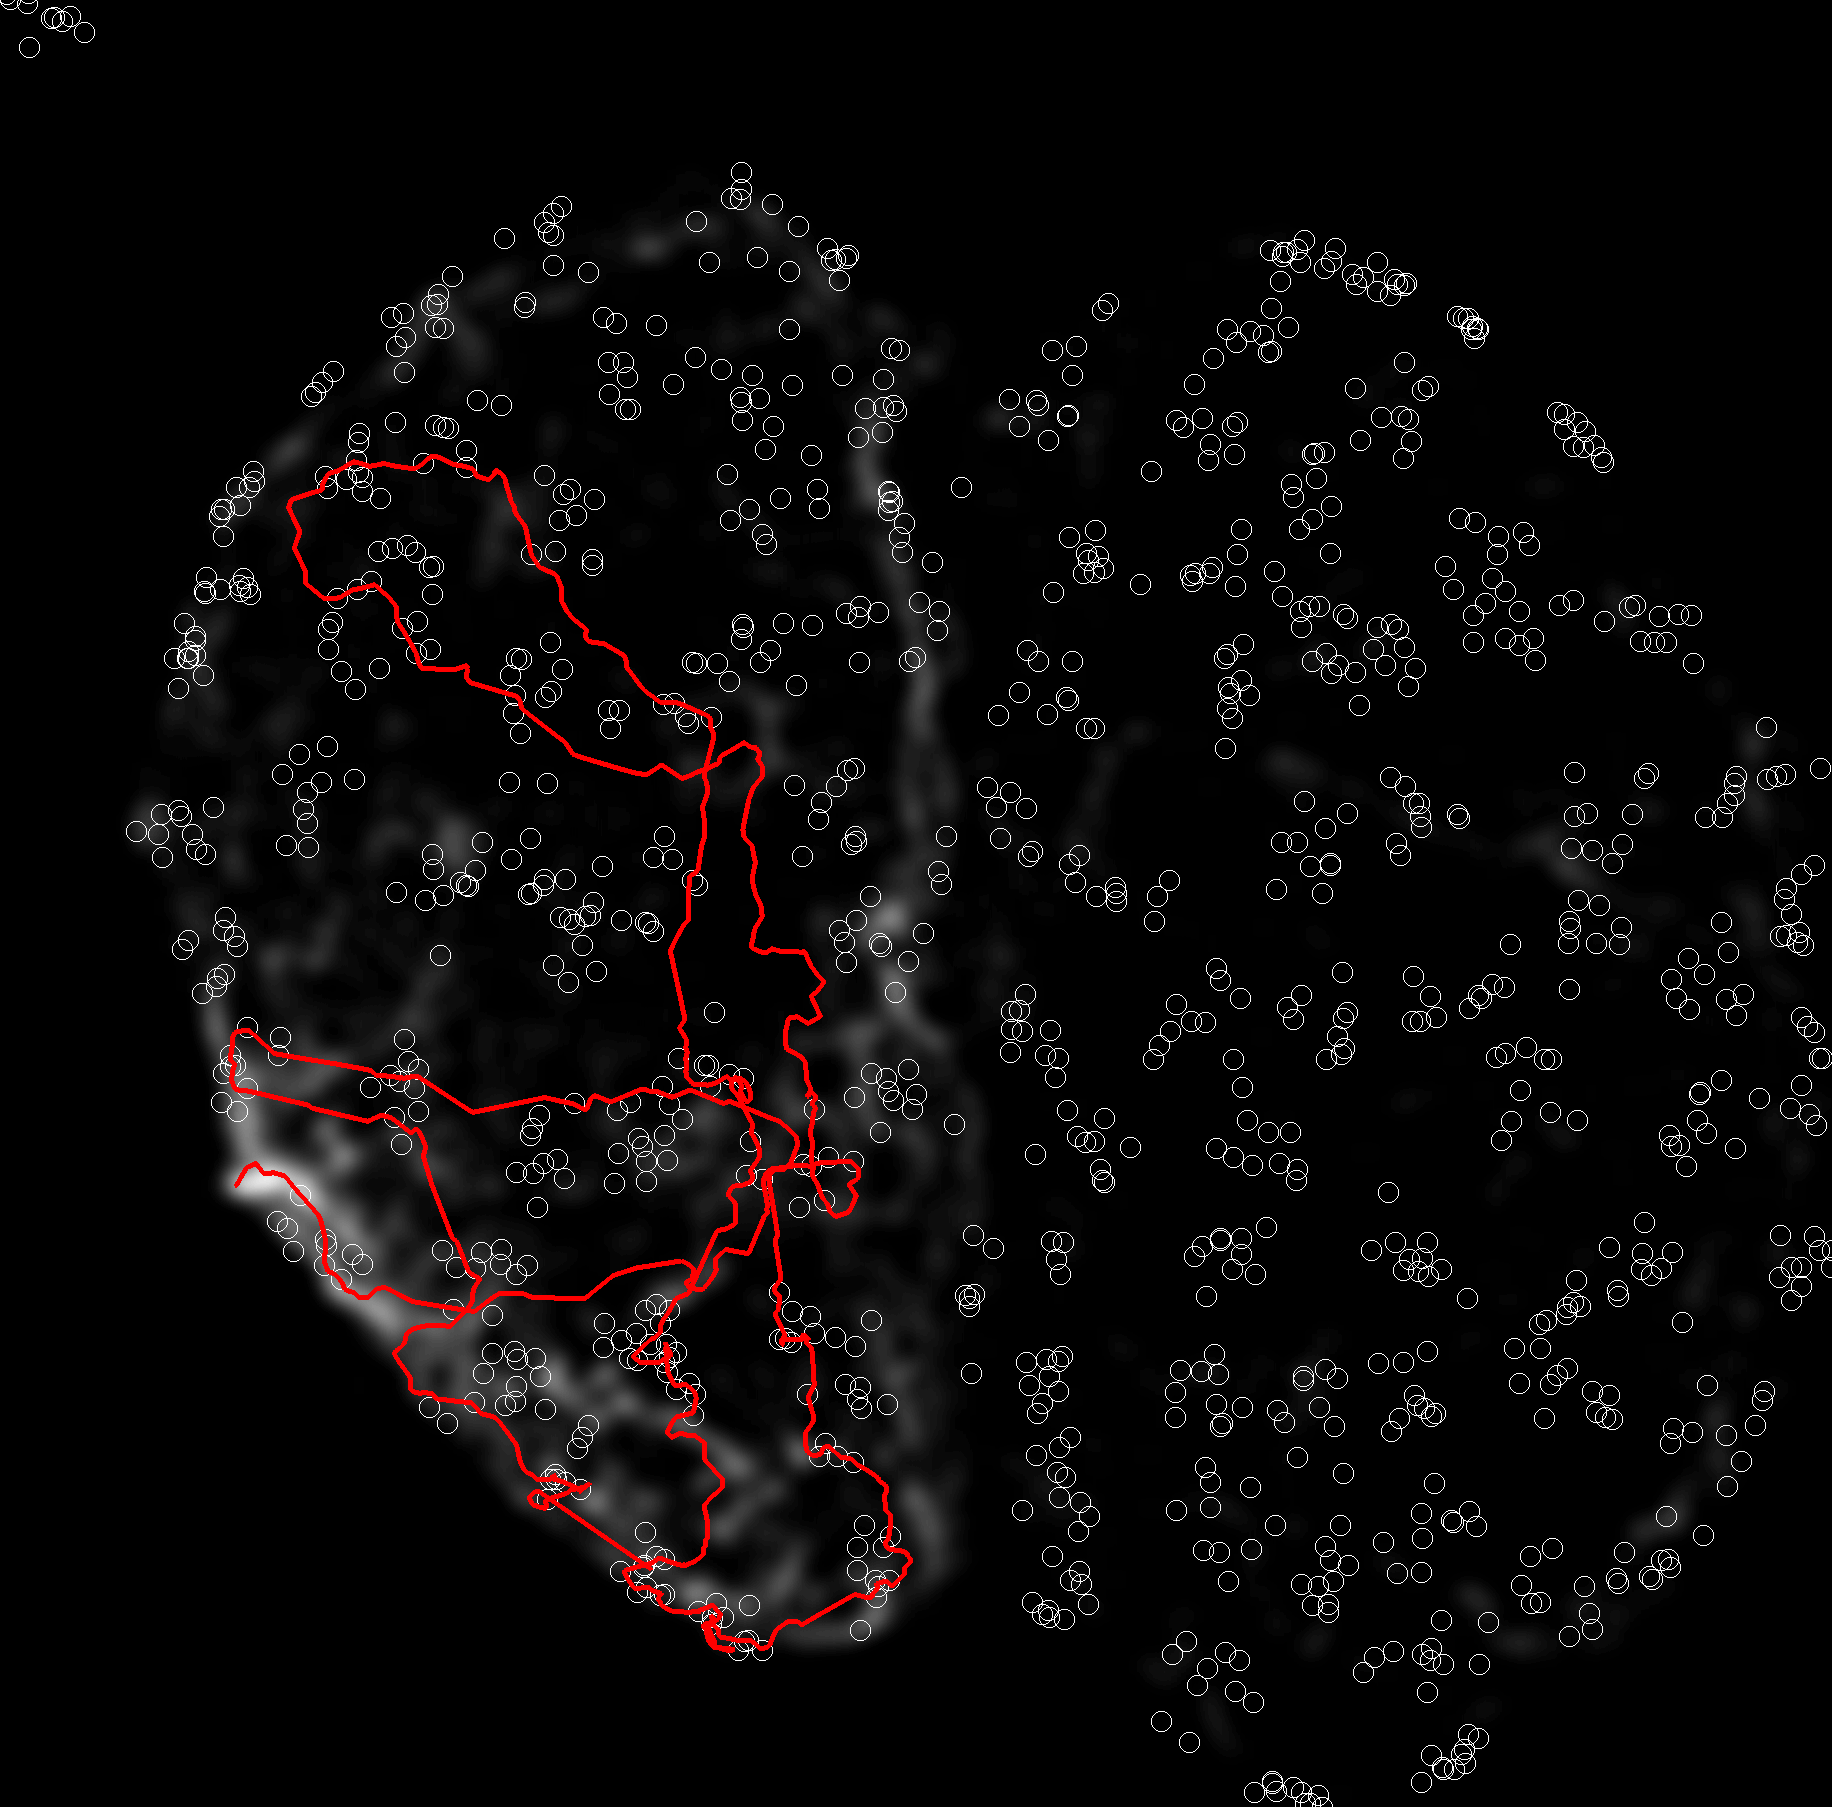

In [8]:
trajectories_img = img.copy().convert("RGB")
alpha_array = (np.array(img_shrooms).sum(axis=2) != 0) * 255
alpha_channel = Image.fromarray(alpha_array.astype(np.uint8), mode="L")
trajectories_img.paste(img_shrooms, mask=alpha_channel)
trajectories_img

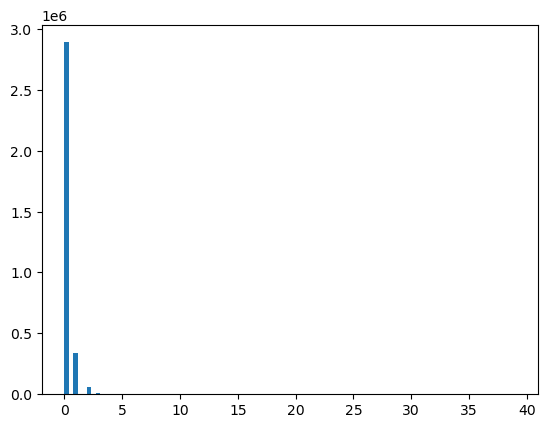

In [9]:
import matplotlib.pyplot as plt
plt.hist(overlayed_trajectories.flatten(), bins = 100)
plt.show()